In [ ]:
# import packages
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2, Lambda, ToTensor
import matplotlib.pyplot as plt


In [ ]:
# import and download data
# transforms images from PIL image formate to normalized tensors - scales image's pixel intensity value from [0,1]
# transforms integer labels to one-hot encoded tensors
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=v2.Compose([
        #v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True)
    ]),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)


test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

100%|██████████| 26421880/26421880 [00:01<00:00, 18765654.27it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 306914.50it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5575609.96it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17713106.64it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
# descriptive statistics
labels = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# find number of samples from each class (6k each)
[out_labels, inverse_indices, counts] = torch.unique(training_data.targets, sorted=True, return_counts=True, return_inverse=True)

<function matplotlib.pyplot.show(close=None, block=None)>

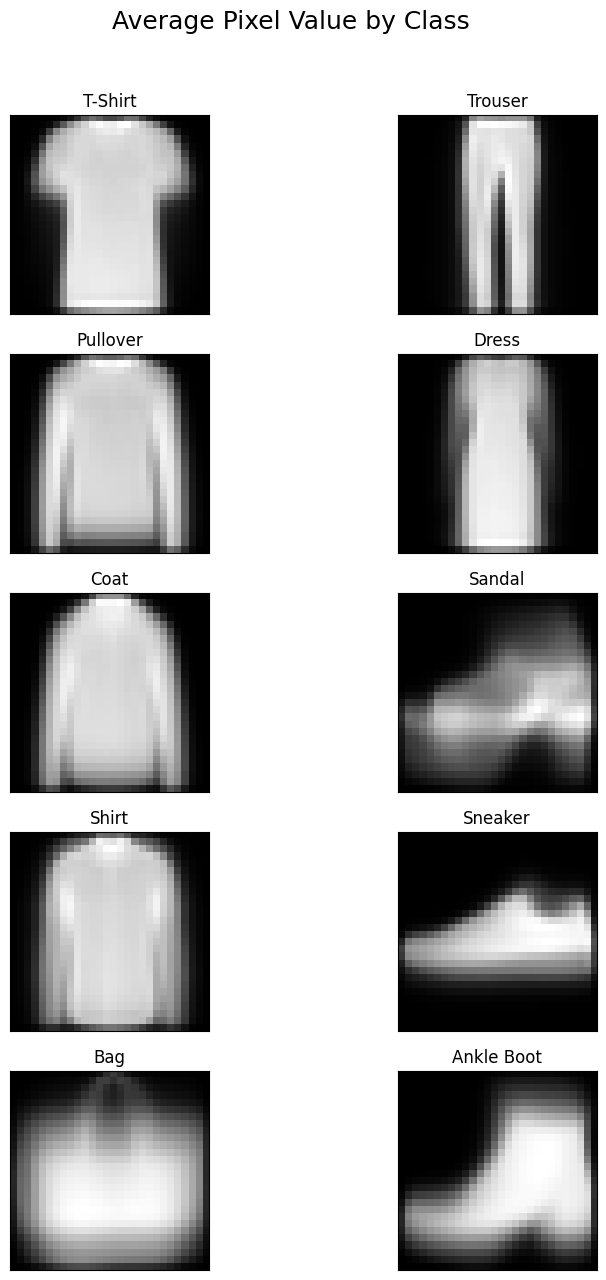

In [ ]:
# get average of all pixels for each clothing type

# define figure/subplots
plt.figure(figsize=(10, 15))
plt.subplots_adjust(hspace=0.2, wspace = 0)
plt.suptitle("Average Pixel Value by Class", fontsize=18, y=0.95)

nonzeros_count_avg = np.empty(10, dtype = 'object')
zeros_count_avg = np.empty(10, dtype = 'object')
avg_img_value = np.empty(20, dtype = 'object')

for n, i_label in enumerate(labels):
  # get average number of black and non-black pixels for each class
  nonzeros_count_avg[n] = torch.count_nonzero(training_data.transform(t_class))/6000
  zeros_count_avg[n] = 28*28-nonzeros_count_avg[n]
  avg_img_value[n] = torch.mean(training_data.transform(t_class))
  avg_img_value[n+10] = torch.std(training_data.transform(t_class))

  # create mask of T/F to get indices that match class i_label
  mask = inverse_indices == i_label
  # index training data given mask
  t_class = training_data.data[mask]
  # set axes and plot info
  ax = plt.subplot(5,2, n+1)
  ax.imshow(torch.mean(training_data.transform(t_class), 0), cmap = "gray")
  ax.set_title(labels[i_label])
  ax.set_xticks([])
  ax.set_yticks([])

plt.show

Text(0.5, 1.0, 'Average number of Non-Black Pixels')

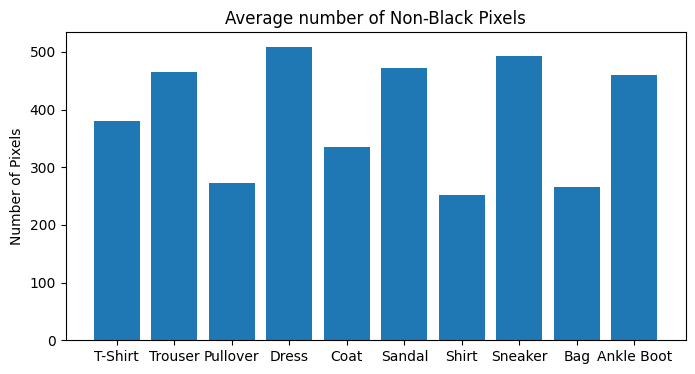

In [ ]:
plt.figure(figsize=(8, 4))
plt.bar(labels.values(),nonzeros_count_avg)
plt.ylabel('Number of Pixels')
plt.title('Average number of Non-Black Pixels')

Text(0.5, 1.0, 'Average pixel value for each class')

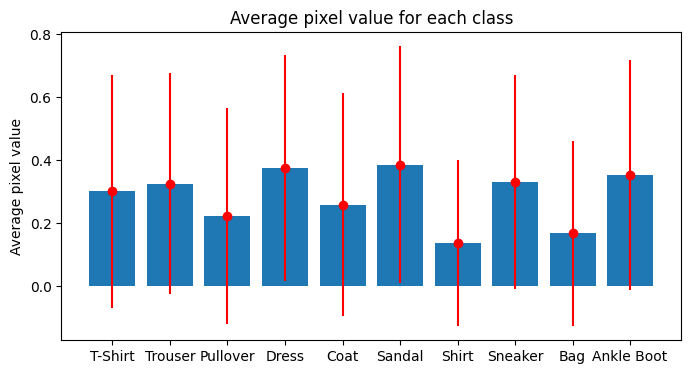

In [ ]:
plt.figure(figsize=(8, 4))
plt.bar(labels.values(),avg_img_value[0:10])
plt.errorbar(labels.values(),avg_img_value[0:10], yerr = avg_img_value[10:20], fmt='o', color='r')
plt.ylabel('Average pixel value')
plt.title('Average pixel value for each class')

In [ ]:
avg_img_value[0:9]

array([tensor(0.3012), tensor(0.3256), tensor(0.2229), tensor(0.3767),
       tensor(0.2589), tensor(0.3853), tensor(0.1367), tensor(0.3318),
       tensor(0.1677)], dtype=object)